Using base_dir = /nfs/roberts/project/pi_co54/bh692/MD_Simulation_CUDA/results/20251209_partial_U_lambda_series/T_1.0
Found 41 CSV files
Saving analysis to /nfs/roberts/project/pi_co54/bh692/MD_Simulation_CUDA/results/20251209_partial_U_lambda_series/T_1.0/data_analysis
Summary of per-lambda statistics:


,lambda_deform,partial_U_mean,partial_U_sem,Ly_mean,n_samples,csv_path,L_tot
0,0.000,-16.734471,11.402364,106.666667,900,/nfs/roberts/project/pi_co54/bh692/MD_Simulati...,NaN
1,0.025,-1.039694,7.786106,106.267416,2000,/nfs/roberts/project/pi_co54/bh692/MD_Simulati...,362.722378
2,0.050,-5.245420,7.939453,105.869660,2000,/nfs/roberts/project/pi_co54/bh692/MD_Simulati...,351.846822
3,0.075,-1.967514,7.898369,105.473392,2000,/nfs/roberts/project/pi_co54/bh692/MD_Simulati...,323.170849
4,0.100,3.576408,11.865936,105.078607,900,/nfs/roberts/project/pi_co54/bh692/MD_Simulati...,NaN
5,0.125,3.606461,7.834243,104.685300,2000,/nfs/roberts/project/pi_co54/bh692/MD_Simulati...,322.200025
6,0.150,1.727895,7.935246,104.293466,2000,/nfs/roberts/project/pi_co54/bh692/MD_Simulati...,344.093469
7,0.175,-1.590064,7.936085,103.903098,2000,/nfs/roberts/project/pi_co54/bh692/MD_Simulati...,323.336841
8,0.200,-9.694845,11.982136,103.514191,900,/nfs/roberts/project/pi_co54/bh692/MD_Simulati...,NaN
9,0.225,10.002421,7.903064,103.126739,2000,/nfs/roberts/project/pi_co54/bh692/MD_Simulati...,313.794808


Linear fit: delta F = 2 * gamma * delta Ly + intercept (weighted)
gamma = 0.00125166 ± 0.0101414, intercept = -0.264285


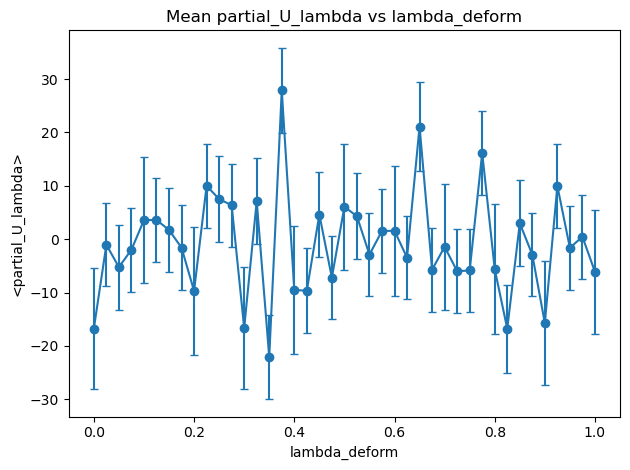

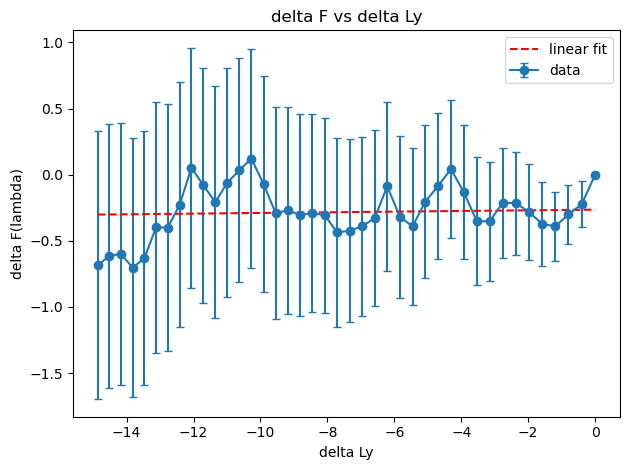

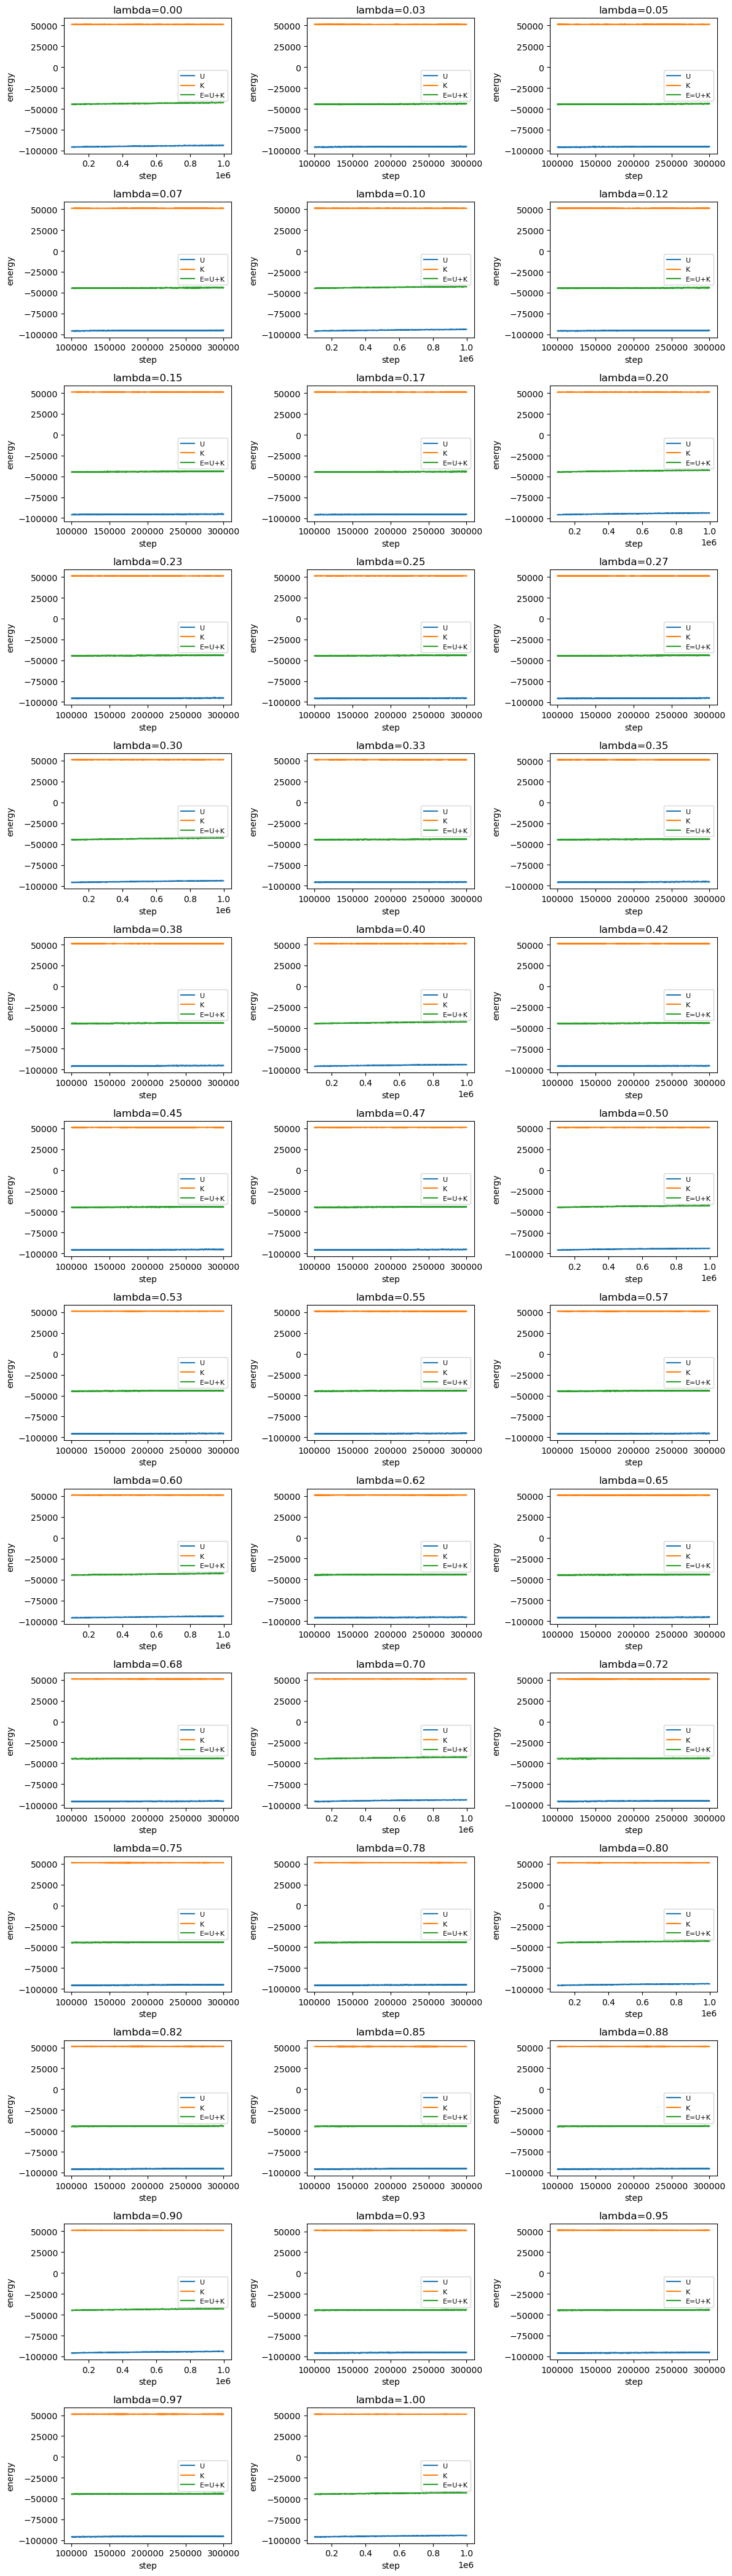

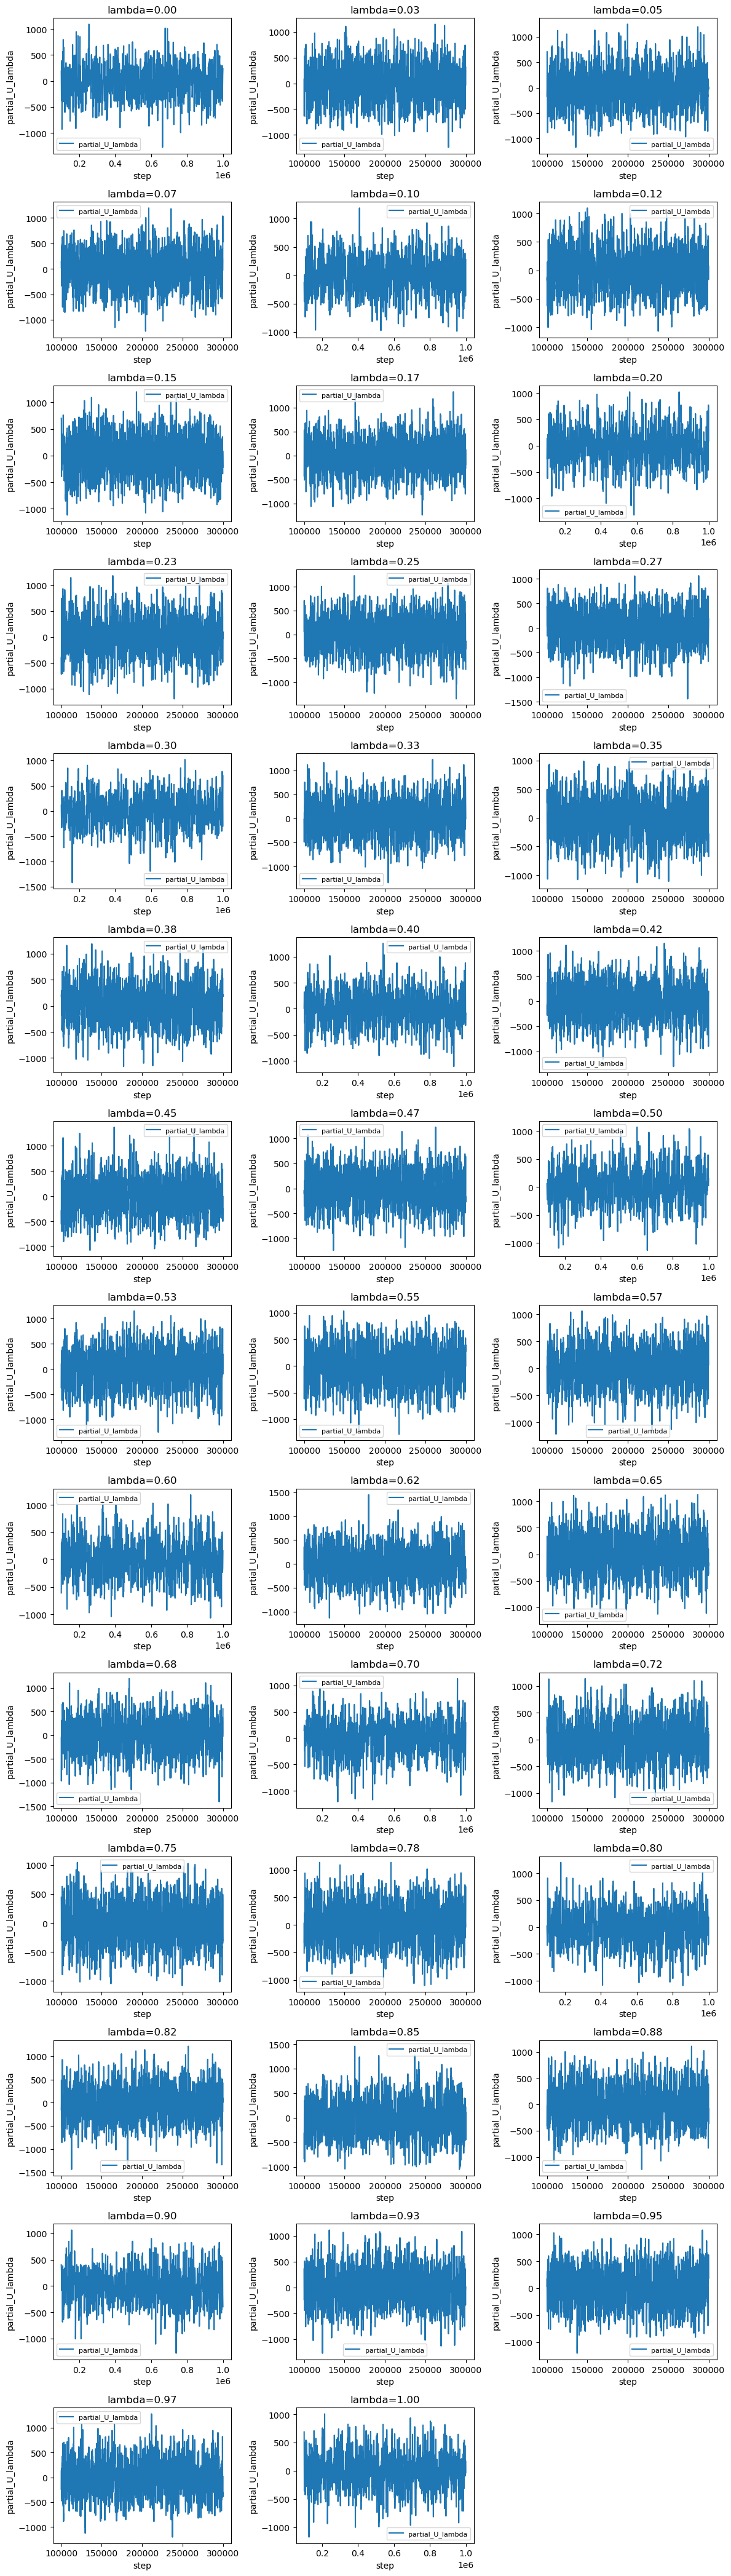

In [ ]:
# Analysis of partial_U_lambda series

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


def row_to_map(row):
    # Convert alternating name,value,... row into a dict.
    vals = [v for v in row.tolist() if pd.notna(v)]
    mapping = {}
    for i in range(0, len(vals) - 1, 2):
        key = str(vals[i]).strip()
        if not key:
            continue
        mapping[key] = vals[i + 1]
    return mapping

# Locate base directory containing the lambda subfolders (robust to where Jupyter is started)
target_rel = Path("results/20251209_partial_U_lambda_series/T_1.0")
cwd = Path.cwd()
for parent in [cwd] + list(cwd.parents):
    candidate = parent / target_rel
    if candidate.exists():
        base_dir = candidate
        break
else:
    raise RuntimeError(f"Could not find base_dir for {target_rel} starting from {cwd}")

csv_paths = sorted(base_dir.glob("*/sample_csv/U_K_tot_log.csv"))
print(f"Using base_dir = {base_dir}")
print(f"Found {len(csv_paths)} CSV files")

output_dir = base_dir / "data_analysis"
output_dir.mkdir(exist_ok=True)
print(f"Saving analysis to {output_dir}")

records = []
timeseries = []
for csv_path in csv_paths:
    # Each line is: name, value, name, value, ... possibly with extra fields (e.g., L_tot)
    # Read as a generic CSV with no header and parse by field names.
    df_raw = pd.read_csv(csv_path, header=None, skipinitialspace=True)

    row_maps = df_raw.apply(row_to_map, axis=1)
    df_kv = pd.DataFrame(list(row_maps))

    if "step" not in df_kv:
        print(f"Skipping {csv_path} (no 'step' column)")
        continue

    steps = pd.to_numeric(df_kv["step"], errors="coerce")
    mask = steps >= 100000
    if not mask.any():
        print(f"Skipping {csv_path} (no data with step >= 100000)")
        continue

    df_sel = df_kv.loc[mask].copy()

    def col(name):
        return pd.to_numeric(df_sel.get(name, pd.Series(dtype=float)), errors="coerce").to_numpy()

    step = col("step")
    u_tot = col("U_tot")
    k_tot = col("K_tot")
    partial_u = col("partial_U_lambda")
    ly = col("Ly")
    lam = col("lambda_deform")
    l_tot = col("L_tot") if "L_tot" in df_sel else None

    lam_mean = np.nanmean(lam)
    partial_mean = np.nanmean(partial_u)
    partial_std = np.nanstd(partial_u, ddof=1) if np.count_nonzero(~np.isnan(partial_u)) > 1 else np.nan
    n = np.count_nonzero(~np.isnan(partial_u))
    partial_sem = partial_std / np.sqrt(n) if n > 0 and np.isfinite(partial_std) else np.nan
    ly_mean = np.nanmean(ly)

    rec = {
        "lambda_deform": lam_mean,
        "partial_U_mean": partial_mean,
        "partial_U_sem": partial_sem,
        "Ly_mean": ly_mean,
        "n_samples": int(n),
        "csv_path": str(csv_path),
    }
    if l_tot is not None:
        l_tot_mean = np.nanmean(l_tot)
        rec["L_tot"] = float(l_tot_mean) if np.isfinite(l_tot_mean) else np.nan
    records.append(rec)

    ts_entry = {
        "lambda_deform": lam_mean,
        "step": step,
        "U_tot": u_tot,
        "K_tot": k_tot,
        "partial_U_lambda": partial_u,
    }
    if l_tot is not None:
        ts_entry["L_tot"] = l_tot
    timeseries.append(ts_entry)

if not csv_paths:
    raise RuntimeError(f"No CSV files found under {base_dir}. Check paths and working directory.")
if not records:
    raise RuntimeError("No usable data found (all files filtered out by step >= 100000)")

summary = pd.DataFrame(records).sort_values("lambda_deform").reset_index(drop=True)
print("Summary of per-lambda statistics:")
display(summary)
summary.to_csv(output_dir / "summary_partial_U_lambda.csv", index=False)

lam = summary["lambda_deform"].to_numpy()
partial_mean = summary["partial_U_mean"].to_numpy()
partial_sem = summary["partial_U_sem"].to_numpy()
ly_mean = summary["Ly_mean"].to_numpy()
delta_ly = ly_mean - ly_mean[0]  # reference at smallest lambda (typically lambda=0)

# --- Fig 1: <partial_U_lambda> vs lambda_deform ---
fig1, ax1 = plt.subplots()
ax1.errorbar(lam, partial_mean, yerr=partial_sem, fmt="o-", capsize=3)
ax1.set_xlabel("lambda_deform")
ax1.set_ylabel("<partial_U_lambda>")
ax1.set_title("Mean partial_U_lambda vs lambda_deform")
fig1.tight_layout()
fig1.savefig(output_dir / "fig1_partialU_vs_lambda.png", dpi=300)

# --- Delta F(lambda) via trapezoidal integration ---
dlam = np.diff(lam)
segment_contrib = 0.5 * dlam * (partial_mean[:-1] + partial_mean[1:])
delta_f = np.zeros_like(lam)
delta_f[1:] = np.cumsum(segment_contrib)

# Error propagation for delta F: assume independent errors on each mean
var = partial_sem ** 2
segment_var = (0.5 * dlam) ** 2 * (var[:-1] + var[1:])
delta_f_err = np.zeros_like(lam)
delta_f_err[1:] = np.sqrt(np.cumsum(segment_var))

# --- Linear regression: delta F vs delta Ly (weighted by delta_F_err) ---
mask_fit = (
    np.isfinite(delta_ly)
    & np.isfinite(delta_f)
    & np.isfinite(delta_f_err)
    & (delta_f_err > 0.0)
)
x = delta_ly[mask_fit]
y = delta_f[mask_fit]
sigma_y = delta_f_err[mask_fit]
w_reg = 1.0 / (sigma_y ** 2)
w_sum = np.sum(w_reg)
x_w = np.sum(w_reg * x) / w_sum
y_w = np.sum(w_reg * y) / w_sum
x_c = x - x_w
y_c = y - y_w
S_xx = np.sum(w_reg * x_c ** 2)
S_xy = np.sum(w_reg * x_c * y_c)
slope = S_xy / S_xx
intercept = y_w - slope * x_w
var_slope = 1.0 / S_xx
gamma = slope / 2.0
gamma_err = np.sqrt(var_slope) / 2.0
print("Linear fit: delta F = 2 * gamma * delta Ly + intercept (weighted)")
print(f"gamma = {gamma:.6g} ± {gamma_err:.6g}, intercept = {intercept:.6g}")
fit_df = pd.DataFrame({
    "delta_Ly": delta_ly[mask_fit],
    "delta_F": delta_f[mask_fit],
    "delta_F_err": delta_f_err[mask_fit],
    "delta_F_fit": slope * delta_ly[mask_fit] + intercept,
})
fit_df.to_csv(output_dir / "deltaF_vs_deltaLy_fit.csv", index=False)
gamma_df = pd.DataFrame({
    "gamma": [gamma],
    "gamma_err": [gamma_err],
    "intercept": [intercept],
})
gamma_df.to_csv(output_dir / "gamma_fit_params.csv", index=False)
x_fit = np.linspace(delta_ly.min(), delta_ly.max(), 100)
y_fit = slope * x_fit + intercept

# --- Fig 2: delta F vs delta Ly ---
fig2, ax2 = plt.subplots()
ax2.errorbar(delta_ly, delta_f, yerr=delta_f_err, fmt="o-", capsize=3, label="data")
ax2.plot(x_fit, y_fit, "r--", label="linear fit")
ax2.set_xlabel("delta Ly")
ax2.set_ylabel("delta F(lambda)")
ax2.set_title("delta F vs delta Ly")
ax2.legend()
fig2.tight_layout()
fig2.savefig(output_dir / "fig2_deltaF_vs_deltaLy.png", dpi=300)

# --- Fig 3: U, K, E vs step for each lambda ---
n = len(timeseries)
ncols = 3
nrows = int(np.ceil(n / ncols))
fig3, axes3 = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharex=False, sharey=False)
axes3 = np.atleast_1d(axes3).ravel()
for i, ts in enumerate(timeseries):
    ax = axes3[i]
    step = ts["step"]
    u_tot = ts["U_tot"]
    k_tot = ts["K_tot"]
    e_tot = u_tot + k_tot
    lam_val = ts["lambda_deform"]
    ax.plot(step, u_tot, label="U")
    ax.plot(step, k_tot, label="K")
    ax.plot(step, e_tot, label="E=U+K")
    ax.set_title(f"lambda={lam_val:.2f}")
    ax.set_xlabel("step")
    ax.set_ylabel("energy")
    ax.legend(fontsize=8)

for ax in axes3[len(timeseries):]:
    ax.axis("off")

fig3.tight_layout()
fig3.savefig(output_dir / "fig3_U_K_E_vs_step.png", dpi=300)

# --- Fig 4: partial_U_lambda vs step for each lambda ---
fig4, axes4 = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharex=False, sharey=False)
axes4 = np.atleast_1d(axes4).ravel()
for i, ts in enumerate(timeseries):
    ax = axes4[i]
    step = ts["step"]
    partial_u = ts["partial_U_lambda"]
    lam_val = ts["lambda_deform"]
    ax.plot(step, partial_u, label="partial_U_lambda")
    ax.set_title(f"lambda={lam_val:.2f}")
    ax.set_xlabel("step")
    ax.set_ylabel("partial_U_lambda")
    ax.legend(fontsize=8)

for ax in axes4[len(timeseries):]:
    ax.axis("off")

fig4.tight_layout()
fig4.savefig(output_dir / "fig4_partialU_vs_step.png", dpi=300)

plt.show()


Linear fit using actual interface length (weighted):
delta F = gamma * L_tot + intercept
gamma = 0.00155544 ± 0.00436282, intercept = -0.793653


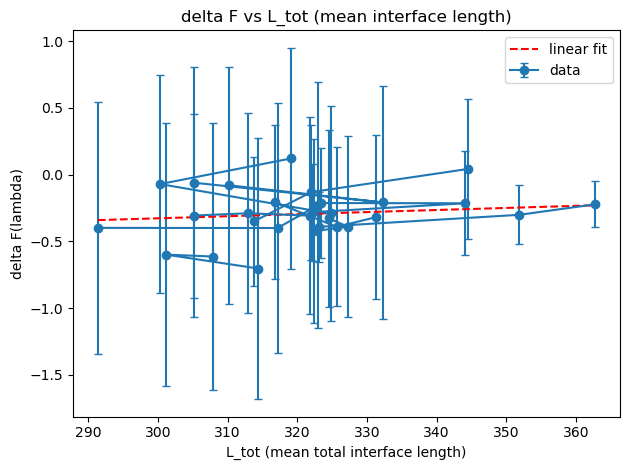

In [51]:
# --- Linear regression: delta F vs L_tot from same CSV (weighted by delta_F_err) ---

if "L_tot" in summary:
    L_tot = summary["L_tot"].to_numpy()
else:
    raise RuntimeError(
        "summary does not contain an 'L_tot' column; rerun earlier cells with L_tot in the input CSV."
    )
sigma_y_L = delta_f_err
mask_fit_L = (
    np.isfinite(L_tot)
    & np.isfinite(delta_f)
    & np.isfinite(sigma_y_L)
    & (sigma_y_L > 0.0)
)

x_L = L_tot[mask_fit_L]
y_L = delta_f[mask_fit_L]
sigma_y_L = sigma_y_L[mask_fit_L]
w_L = 1.0 / (sigma_y_L ** 2)
w_L_sum = np.sum(w_L)
x_L_w = np.sum(w_L * x_L) / w_L_sum
y_L_w = np.sum(w_L * y_L) / w_L_sum
x_L_c = x_L - x_L_w
y_L_c = y_L - y_L_w
S_xx_L = np.sum(w_L * x_L_c ** 2)
S_xy_L = np.sum(w_L * x_L_c * y_L_c)
gamma_L = S_xy_L / S_xx_L
intercept_L = y_L_w - gamma_L * x_L_w
var_gamma_L = 1.0 / S_xx_L
gamma_L_err = float(np.sqrt(var_gamma_L))

print("Linear fit using actual interface length (weighted):")
print("delta F = gamma * L_tot + intercept")
print(f"gamma = {gamma_L:.6g} ± {gamma_L_err:.6g}, intercept = {intercept_L:.6g}")

fit_L_df = pd.DataFrame({
    "L_tot_mean": L_tot[mask_fit_L],
    "delta_F": delta_f[mask_fit_L],
    "delta_F_err": delta_f_err[mask_fit_L],
    "delta_F_fit": gamma_L * L_tot[mask_fit_L] + intercept_L,
})
fit_L_df.to_csv(output_dir / "deltaF_vs_Ltot_fit.csv", index=False)

gamma_L_df = pd.DataFrame({
    "gamma_Ltot": [gamma_L],
    "gamma_Ltot_err": [gamma_L_err],
    "intercept": [intercept_L],
})
gamma_L_df.to_csv(output_dir / "gamma_Ltot_fit_params.csv", index=False)

# --- Plot: delta F vs L_tot_mean ---
x_fit_L = np.linspace(np.nanmin(L_tot), np.nanmax(L_tot), 100)
y_fit_L = gamma_L * x_fit_L + intercept_L

fig5, ax5 = plt.subplots()
ax5.errorbar(L_tot, delta_f, yerr=delta_f_err, fmt="o-", capsize=3, label="data")
ax5.plot(x_fit_L, y_fit_L, "r--", label="linear fit")
ax5.set_xlabel("L_tot (mean total interface length)")
ax5.set_ylabel("delta F(lambda)")
ax5.set_title("delta F vs L_tot (mean interface length)")
ax5.legend()
fig5.tight_layout()
fig5.savefig(output_dir / "fig5_deltaF_vs_Ltot.png", dpi=300)

plt.show()


In [31]:
# --- Run average_cwa.py for each lambda: CWA analysis ---

from pathlib import Path
import subprocess
import sys

# We reuse base_dir from the first cell, but here we may want to point to a specific temperature.
# Example: T = 0.5 as in the cwa_instant.csv paths shown.
T_value = 1.0
base_dir_cwa = None
for parent in [Path.cwd()] + list(Path.cwd().parents):
    candidate = parent / f"results/20251209_partial_U_lambda_series/T_{T_value}"
    if candidate.exists():
        base_dir_cwa = candidate
        break
if base_dir_cwa is None:
    raise RuntimeError(f"Could not find base_dir for CWA at T={T_value}")

print(f"Running CWA averages under {base_dir_cwa}")

# Locate average_cwa.py robustly (whether the notebook is run from the repo root or from the python/ subdir)
script_rel = Path("python") / "average_cwa.py"
average_cwa_path = None
for parent in [Path.cwd()] + list(Path.cwd().parents):
    candidate = parent / script_rel
    if candidate.exists():
        average_cwa_path = candidate
        break
if average_cwa_path is None:
    raise RuntimeError("Could not find average_cwa.py relative to current working directory")

print(f"Using average_cwa.py at {average_cwa_path}")

# Loop over all lambda_* subdirectories that contain sample_csv/cwa_instant.csv
for lambda_dir in sorted(base_dir_cwa.glob("lambda_*/")):
    sample_csv = lambda_dir / "sample_csv" / "cwa_instant.csv"
    if not sample_csv.exists():
        print(f"[skip] No cwa_instant.csv in {lambda_dir}")
        continue

    # Extract the numeric lambda value from directory name, e.g. lambda_0.3 -> 0.3
    try:
        lam_str = lambda_dir.name.split("lambda_")[1]
    except Exception:
        lam_str = lambda_dir.name

    # Construct output paths that keep the numeric lambda in the filename
    out_svg = base_dir_cwa / "data_analysis" / f"average_cwa_lambda_{lam_str}.svg"
    out_csv = base_dir_cwa / "data_analysis" / f"average_cwa_lambda_{lam_str}.csv"
    out_svg.parent.mkdir(parents=True, exist_ok=True)

    cmd = [
        sys.executable,
        str(average_cwa_path),
        "--input",
        str(sample_csv),
        "--out-svg-path",
        str(out_svg),
        "--out-csv-path",
        str(out_csv),
    ]
    print("Running:", " ".join(cmd))
    result = subprocess.run(cmd, check=False)
    if result.returncode != 0:
        print(f"[warning] average_cwa.py failed for {lambda_dir} with code {result.returncode}")
    else:
        print(f"[done] CWA average for {lambda_dir} -> {out_svg}, {out_csv}")


Running CWA averages under /nfs/roberts/project/pi_co54/bh692/MD_Simulation_CUDA/results/20251209_partial_U_lambda_series/T_1.0
Using average_cwa.py at /nfs/roberts/project/pi_co54/bh692/MD_Simulation_CUDA/python/average_cwa.py
Running: /home/bh692/.conda/envs/py3/bin/python /nfs/roberts/project/pi_co54/bh692/MD_Simulation_CUDA/python/average_cwa.py --input /nfs/roberts/project/pi_co54/bh692/MD_Simulation_CUDA/results/20251209_partial_U_lambda_series/T_1.0/lambda_0.0/sample_csv/cwa_instant.csv --out-svg-path /nfs/roberts/project/pi_co54/bh692/MD_Simulation_CUDA/results/20251209_partial_U_lambda_series/T_1.0/data_analysis/average_cwa_lambda_0.0.svg --out-csv-path /nfs/roberts/project/pi_co54/bh692/MD_Simulation_CUDA/results/20251209_partial_U_lambda_series/T_1.0/data_analysis/average_cwa_lambda_0.0.csv
Average gamma from C(q) (via avg S(q)) fit: 0.080838, C0=3.635136e-03
mode  3: q^2=0.031228, avg |h_q|^2=1.731724e+00, C(q) from avg S(q)=5.413681e-03
mode  4: q^2=0.055517, avg |h_q|^2=1

In [32]:
# --- Aggregate CWA line tension (gamma) over all lambdas ---

import numpy as np
import pandas as pd
from pathlib import Path

# Temperature to analyze (must match the CWA cell above)

# Locate the base directory for this temperature
base_dir_cwa = None
for parent in [Path.cwd()] + list(Path.cwd().parents):
    candidate = parent / f"results/20251209_partial_U_lambda_series/T_{T_value}"
    if candidate.exists():
        base_dir_cwa = candidate
        break
if base_dir_cwa is None:
    raise RuntimeError(f"Could not find base_dir for CWA at T={T_value}")

cwa_analysis_dir = base_dir_cwa / "data_analysis"
print(f"Collecting CWA gamma values from {cwa_analysis_dir}")

records = []
for csv_path in sorted(cwa_analysis_dir.glob("average_cwa_lambda_*.csv")):
    name = csv_path.stem  # e.g. average_cwa_lambda_0.0
    try:
        lam_str = name.split("lambda_")[1]
        lam_val = float(lam_str)
    except Exception:
        lam_val = float("nan")

    gamma_val = float("nan")
    with csv_path.open("r", encoding="utf-8") as f:
        # First line is header: index,value
        header = f.readline()
        for line in f:
            if line.startswith("gamma,"):
                parts = line.strip().split(",")
                if len(parts) >= 2:
                    try:
                        gamma_val = float(parts[1])
                    except ValueError:
                        gamma_val = float("nan")
                break

    records.append({
        "lambda_deform": lam_val,
        "gamma_cwa": gamma_val,
        "path": str(csv_path),
    })

if not records:
    raise RuntimeError(f"No average_cwa_lambda_*.csv files found in {cwa_analysis_dir}")

cwa_summary = pd.DataFrame(records).sort_values("lambda_deform").reset_index(drop=True)
print("CWA gamma per lambda:")
display(cwa_summary[["lambda_deform", "gamma_cwa"]])

# Compute average gamma over all lambdas
valid = np.isfinite(cwa_summary["gamma_cwa"].to_numpy())
if not valid.any():
    raise RuntimeError("No finite gamma_cwa values found to average")

gamma_vals = cwa_summary.loc[valid, "gamma_cwa"].to_numpy()
gamma_mean = float(np.mean(gamma_vals))
gamma_std = float(np.std(gamma_vals, ddof=1)) if gamma_vals.size > 1 else float("nan")
gamma_sem = float(gamma_std / np.sqrt(gamma_vals.size)) if gamma_vals.size > 1 else float("nan")

print(f"Average CWA gamma over {gamma_vals.size} lambdas:")
print(f"  mean = {gamma_mean:.6g}")
if np.isfinite(gamma_sem):
    print(f"  std  = {gamma_std:.6g}")
    print(f"  SEM  = {gamma_sem:.6g}")

# Save to CSV for downstream analysis
cwa_summary["gamma_mean_all_lambdas"] = gamma_mean
cwa_summary["gamma_std_all_lambdas"] = gamma_std
cwa_summary["gamma_sem_all_lambdas"] = gamma_sem

out_path = cwa_analysis_dir / "cwa_gamma_over_lambdas.csv"
cwa_summary.to_csv(out_path, index=False)
print(f"Saved CWA gamma summary to {out_path}")


CWA gamma per lambda:


,lambda_deform,gamma_cwa
0,0.000,0.080838
1,0.025,0.150829
2,0.050,0.151757
3,0.075,0.282655
4,0.100,0.076956
5,0.125,0.170373
6,0.150,0.240251
7,0.175,0.225187
8,0.200,0.068871
9,0.225,0.234481


Average CWA gamma over 41 lambdas:
  mean = 0.150169
  std  = 0.0632689
  SEM  = 0.00988094
Saved CWA gamma summary to /nfs/roberts/project/pi_co54/bh692/MD_Simulation_CUDA/results/20251209_partial_U_lambda_series/T_1.0/data_analysis/cwa_gamma_over_lambdas.csv


Pressure base_dir = /nfs/roberts/project/pi_co54/bh692/MD_Simulation_CUDA/results/20251209_partial_U_lambda_series/T_0.7
gamma (pressure) for lambda=0.25: -0.05443054163908163
[skip] missing /nfs/roberts/project/pi_co54/bh692/MD_Simulation_CUDA/results/20251209_partial_U_lambda_series/T_0.7/lambda_0.0/sample_csv/pressure_profile.csv
[skip] missing /nfs/roberts/project/pi_co54/bh692/MD_Simulation_CUDA/results/20251209_partial_U_lambda_series/T_0.7/lambda_0.1/sample_csv/pressure_profile.csv
[skip] missing /nfs/roberts/project/pi_co54/bh692/MD_Simulation_CUDA/results/20251209_partial_U_lambda_series/T_0.7/lambda_0.2/sample_csv/pressure_profile.csv
[skip] missing /nfs/roberts/project/pi_co54/bh692/MD_Simulation_CUDA/results/20251209_partial_U_lambda_series/T_0.7/lambda_0.3/sample_csv/pressure_profile.csv
[skip] missing /nfs/roberts/project/pi_co54/bh692/MD_Simulation_CUDA/results/20251209_partial_U_lambda_series/T_0.7/lambda_0.4/sample_csv/pressure_profile.csv
[skip] missing /nfs/roberts/p

,lambda_deform,gamma_pressure
0,0.025,-0.085969
1,0.050,0.043820
2,0.075,-0.046615
3,0.125,-0.062003
4,0.150,0.030588
5,0.175,-0.056595
6,0.225,-0.120340
7,0.250,-0.054431
8,0.275,0.017247
9,0.325,-0.151562


Mean gamma (pressure) over all lambda for T=0.7: -0.07727780798537646


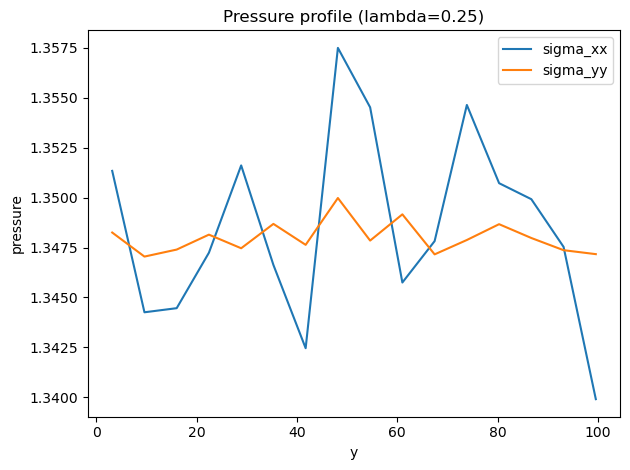

In [7]:
# --- Pressure profile and surface tension (gamma) from Pxx/Pyy ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Temperature and lambda to analyze
T_value_pressure = 0.7
lambda_value_pressure = 0.25
step_min_pressure = 100000

def locate_base_dir_for_T(T_val: float) -> Path:
    target_rel = Path(f"results/20251209_partial_U_lambda_series/T_{T_val}")
    for parent in [Path.cwd()] + list(Path.cwd().parents):
        candidate = parent / target_rel
        if candidate.exists():
            return candidate
    raise RuntimeError(f"Could not find base_dir for T={T_val}")


def load_pressure_profile(path: Path, step_min: int = 0):
    if not path.exists():
        print(f"[skip] missing {path}")
        return None
    # skip header row that contains column labels
    df = pd.read_csv(path, header=None, skiprows=1)
    if df.empty:
        print(f"[skip] empty pressure profile: {path}")
        return None

    steps = pd.to_numeric(df.iloc[:, 0], errors="coerce")
    mask = steps > step_min
    df = df.loc[mask]
    if df.empty:
        print(f"[skip] no rows after step>{step_min} in {path}")
        return None

    try:
        n_bins = int(df.iloc[0, 1])
        ly = float(df.iloc[0, 3])
    except Exception as exc:
        print(f"[warn] failed to parse metadata from {path}: {exc}")
        return None

    values = df.iloc[:, 4:].to_numpy(dtype=float)
    expected_cols = 3 * n_bins
    if values.shape[1] < expected_cols:
        print(f"[warn] expected >= {expected_cols} cols of pressure data, got {values.shape[1]} in {path}")
        return None
    values = values[:, :expected_cols]

    pxx = values[:, 0:n_bins]
    pyy = values[:, n_bins:2*n_bins]
    pxy = values[:, 2*n_bins:3*n_bins]
    y = (np.arange(n_bins) + 0.5) * ly / n_bins
    return {
        "steps": steps.loc[mask].to_numpy(),
        "pxx": pxx,
        "pyy": pyy,
        "pxy": pxy,
        "ly": ly,
        "y": y,
        "n_bins": n_bins,
    }


base_dir_pressure = locate_base_dir_for_T(T_value_pressure)
print(f"Pressure base_dir = {base_dir_pressure}")

pressure_path = base_dir_pressure / f"lambda_{lambda_value_pressure}" / "sample_csv" / "pressure_profile.csv"
data = load_pressure_profile(pressure_path, step_min=step_min_pressure)
if data is not None:
    pxx_mean = np.nanmean(data["pxx"], axis=0)
    pyy_mean = np.nanmean(data["pyy"], axis=0)
    y = data["y"]
    ly = data["ly"]

    fig, ax = plt.subplots()
    ax.plot(y, pxx_mean, label="sigma_xx")
    ax.plot(y, pyy_mean, label="sigma_yy")
    ax.set_xlabel("y")
    ax.set_ylabel("pressure")
    ax.set_title(f"Pressure profile (lambda={lambda_value_pressure})")
    ax.legend()
    fig.tight_layout()
    fig.savefig(base_dir_pressure / "data_analysis" / f"pressure_profile_lambda_{lambda_value_pressure}.png", dpi=300)

    gamma_lambda = float(np.nanmean(pyy_mean - pxx_mean) * ly)
    print(f"gamma (pressure) for lambda={lambda_value_pressure}: {gamma_lambda}")
else:
    gamma_lambda = float("nan")

# Aggregate gamma over all lambda values for this T
all_gamma = []
for lam_dir in sorted(base_dir_pressure.glob("lambda_*/")):
    lam_name = lam_dir.name
    try:
        lam_val = float(lam_name.split("lambda_")[1])
    except Exception:
        lam_val = float("nan")
    p_path = lam_dir / "sample_csv" / "pressure_profile.csv"
    d = load_pressure_profile(p_path, step_min=step_min_pressure)
    if d is None:
        continue
    pxx_m = np.nanmean(d["pxx"], axis=0)
    pyy_m = np.nanmean(d["pyy"], axis=0)
    gamma_val = float(np.nanmean(pyy_m - pxx_m) * d["ly"])
    all_gamma.append({"lambda_deform": lam_val, "gamma_pressure": gamma_val})

if all_gamma:
    gamma_df = pd.DataFrame(all_gamma).sort_values("lambda_deform")
    display(gamma_df)
    gamma_mean_all = float(gamma_df["gamma_pressure"].mean())
    print(f"Mean gamma (pressure) over all lambda for T={T_value_pressure}: {gamma_mean_all}")
else:
    print(f"No gamma values computed for T={T_value_pressure}")
